# Testing Porespy with 3D image 288x288x300

In [30]:
import porespy as ps
import matplotlib.pyplot as plt
import matplotlib.image as imgag
import imageio
import numpy as np
import scipy as sp
import scipy.ndimage as spim
import openpnm as op
from porespy.filters import find_peaks, trim_saddle_points, trim_nearby_peaks
from skimage.morphology import watershed
from porespy.tools import randomize_colors

In [31]:
#%ls
im=np.load('mtest3Dimage.npy')
im.shape

(288, 288, 300)

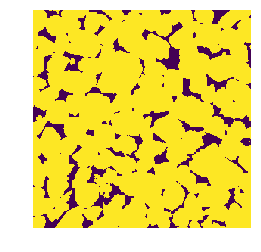

In [32]:
plt.imshow(im[:,:,299])
plt.axis('off')
plt.show()

(-0.5, 299.5, 287.5, -0.5)

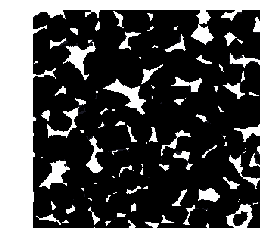

In [33]:
plt.imshow(ps.visualization.sem(im), cmap=plt.cm.bone)
plt.axis('off')

In [34]:
im = np.array(im, dtype=bool)

In [35]:

snow_output = ps.network_extraction.snow(im,
                                        voxel_size=7.5e-6,
                                        boundary_faces=['left','right','front','back','top','bottom'],
                                        marching_cubes_area=False)

____________________________________________________________
Beginning SNOW Algorithm
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1970
Peaks after trimming saddle points:  1482
Peaks after trimming nearby peaks:  1425


c:\users\mt\anaconda3\lib\site-packages\skimage\util\arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


____________________________________________________________
Extracting pore and throat information from image


100%|██████████████████████████████████████████████████████████████████████████████| 2199/2199 [00:43<00:00, 50.36it/s]


In [36]:
pn = op.network.GenericNetwork()
pn.update(snow_output)
prj = pn.project

Text(0,0.5,'PDF')

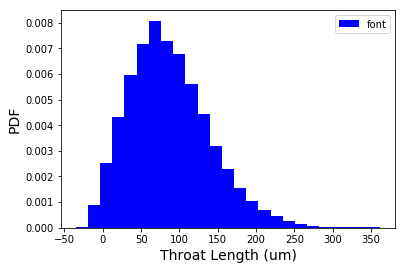

In [42]:
plt.hist(1e6*pn['throat.length'],25,color='b',density='true',label='font') # 
plt.legend(loc='upper right')
plt.xlabel('Throat Length (um)',fontsize=14)
plt.ylabel('PDF',fontsize=14)

# !!!! Issue with the extracted network ??

In [45]:

min(pn['throat.length']) # <0 !!!!

-3.510435161948927e-05

In [38]:
prj.export_data(filename='v4FONTextraction', filetype='vtk')

In [39]:
im = ps.tools.align_image_with_openpnm(im)
ps.io.to_vtk(sp.array(im, dtype=int), 'v4Fontim.tif')
#ps.io.to_vtk(np.array(im, dtype=np.uint8),'v3Font.tif')
#ps.io.to_vtk(np.array(im, dtype=np.uint8),'v3Font.tif')

In [12]:
pn.labels()

['pore.all', 'pore.back', 'pore.bottom', 'pore.boundary', 'pore.front', 'pore.internal', 'pore.left', 'pore.right', 'pore.top', 'throat.all', 'throat.boundary', 'throat.internal']

In [23]:
water = op.phases.Water(network=pn)
#pn['pore.diameter'] = 2*pn['pore.radius']
#pn['throat.diameter'] = 2*pn['throat.radius']
pn.add_model(propname='pore.area',
             model=op.models.geometry.pore_area.sphere)
pn.add_model(propname='throat.area',
             model=op.models.geometry.throat_area.cylinder)
pn.add_model(propname='throat.endpoints',
             model=op.models.geometry.throat_endpoints.spherical_pores)
pn.add_model(propname='throat.conduit_lengths',
             model=op.models.geometry.throat_length.conduit_lengths)

In [24]:
water.add_model(propname='throat.hydraulic_conductance',
                model=op.models.physics.hydraulic_conductance.hagen_poiseuille)

In [25]:
flow = op.algorithms.StokesFlow(network=pn, phase=water)
flow.set_value_BC(pores=pn.pores('front'), values=200000)
flow.set_value_BC(pores=pn.pores('back'), values=100000)
flow.run()

# !!!! permeability is off compared to other methods 

In [26]:
mu = sp.mean(water['pore.viscosity'])
# Specify a pressure difference (in Pa)
delta_P = 100000
# Using the rate method of the StokesFlow algorithm
Q = sp.absolute(flow.rate(pores=pn.pores('front')))
# Because we know the inlets and outlets are at x=0 and x=X
Lx = sp.amax(pn['pore.coords'][:, 2]) - sp.amin(pn['pore.coords'][:, 2])
print(Lx)
A = Lx*Lx  # Since the network is cubic Lx = Ly = Lz
K = Q*mu*Lx/(delta_P*A)
print(K)

print('K(mD)=',K/9.869233e-16)

0.0022724999999999998
[2.79592187e-11]
K(mD)= [28329.67738199]
